# Visualizing Twitter Community Graph Network with Plotly

In the first script in this repo, I gathered the Tweets, usernames, and friends of a community that participated in a Twitter chat. This script can be used to visualize the network with Plotly.

In [133]:
import plotly.plotly as py
from plotly.graph_objs import *

import networkx as nx
import pandas as pd

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline 

The CSV in question has 4 columns, a list of usernames that the friendship originates from, a list of user IDs that the friendship originates from, a list of usernames that the friendship points to, and a list of user IDs that the friendship points to. We will name the nodes with the user IDs and user the usernames as a characteristic of the nodes.

In [136]:
df = pd.read_csv('dfCommunity.csv')

In [138]:
df = df[index]

In [139]:
# Convert user ID from float to integer.
df.userFromId=df.userFromId.apply(lambda x: int(x))
df.userToId=df.userToId.apply(lambda x: int(x))

This is a directed graph since Twitter relationships are not necessarily reciprocal. Although Plotly does not offer a simple way to visualize this insofar that I am aware unlike Gephi, contructing the graph in this way will allow for easier display later of followers, following, etc.

In [141]:
G = nx.DiGraph()
#G = nx.Graph()
G.add_nodes_from(df['userFromId'])
#G.add_edges_from(zip(df['userFromId'],df['userToId']))

In [142]:
temp = zip(df['userFromId'],df['userToId'])
G.add_edges_from(temp)

In [143]:
# Give nodes their Usernames
dfLookup = df[['userFromName','userFromId']].drop_duplicates()

In [144]:
dfLookup.head()
for userId in dfLookup['userFromId']:
    temp = dfLookup['userFromName'][df['userFromId']==userId]
    G.node[userId]['userName'] = temp.values[0]

## Configure Position
The cell that follows is only to experiment with possible node positioning. The NetworkX Spring Layout positioning can be manipulated somewhat with the "k=" and "iterations=" parameters. 

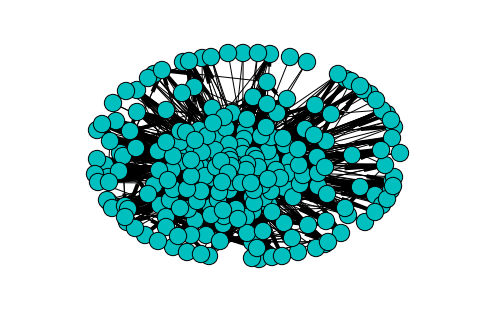

In [368]:
nx.draw(G, pos=nx.spring_layout(G,k=.12),node_color='c',edge_color='k')

## Define Positioning

Plotly does not have a truth library for graph theory. We will use NetworkX to define the position of coordinates of a scatterplot and the attributes to describe the nodes of that scatterplot. Once a positioning is determined above, define it below as "pos", a dictionary of x and y coordinates.

In [178]:
pos=nx.spring_layout(G,k=.12)

Plotly allows for display of any measures calculated. Some possible measures include indegree (followers), outdegree (following) and centrality.

In [180]:
centralScore = nx.betweenness_centrality(G)
inScore = G.in_degree()
outScore = G.out_degree()

## Define scatter_nodes() and scatter_edges()

These functions create Plotly "traces" of the nodes and edges using the layout defined in "pos". Here, I have chosen to color the nodes by the betweenness centrality, but one might choose to vary size of the nodes instead, or vary by another characteristic such as degree. 

In [332]:
# Get a list of all nodeID in ascending order
nodeID = G.node.keys()
nodeID.sort()

In [330]:
def scatter_nodes(pos, labels=None, color='rgb(152, 0, 0)', size=8, opacity=1):
    # pos is the dict of node positions
    # labels is a list  of labels of len(pos), to be displayed when hovering the mouse over the nodes
    # color is the color for nodes. When it is set as None the Plotly default color is used
    # size is the size of the dots representing the nodes
    # opacity is a value between [0,1] defining the node color opacity

    trace = Scatter(x=[], 
                    y=[],  
                    mode='markers', 
                    marker=Marker(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='Greens',
        reversescale=True,
        color=[], 
        size=10,         
        colorbar=dict(
            thickness=15,
            title='Betweeenness Centrality',
            xanchor='left',
            titleside='right'
        ),
    line=dict(width=2)))
    for nd in nodeID:
        trace['x'].append(pos[nd][0])
        trace['y'].append(pos[nd][1])
        trace['marker']['color'].append(centralScore[nd])
    attrib=dict(name='', text=labels , hoverinfo='text', opacity=opacity) # a dict of Plotly node attributes
    trace=dict(trace, **attrib)# concatenate the dict trace and attrib
    trace['marker']['size']=size

    return trace       

In [331]:
def scatter_edges(G, pos, line_color='#a3a3c2', line_width=1, opacity=.2):
    trace = Scatter(x=[], 
                    y=[], 
                    mode='lines',
                   )
    for edge in G.edges():
        trace['x'] += [pos[edge[0]][0],pos[edge[1]][0], None]
        trace['y'] += [pos[edge[0]][1],pos[edge[1]][1], None]  
        trace['hoverinfo']='none'
        trace['line']['width']=line_width
        if line_color is not None: # when it is None a default Plotly color is used
            trace['line']['color']=line_color
    return trace          

In [347]:
# Node label information available on hover. Note that some html tags such as line break <br> are recognized within a string.
labels = []

for nd in nodeID:
      labels.append(G.node[nd]['userName'] + "<br>" + "Followers: " + str(inScore[nd]) + "<br>" + "Following: " + str(outScore[nd]) + "<br>" + "Centrality: " + str("%0.3f" % centralScore[nd]))

In [350]:
trace1=scatter_edges(G, pos)
trace2=scatter_nodes(pos, labels=labels)

## Configure the plot and call Plotly

In [365]:
width=600
height=600
axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )
layout=Layout(title= '#EdTechChat Community on Twitter',
    font= Font(),
    showlegend=False,
    autosize=False,
    width=width,
    height=height,
    xaxis=dict(
        title='Dec 14, 2015 9-10 p.m. EST, #EdTechChat #NETP16   www.techpoweredmath.com',
        titlefont=dict(
        size=14,
        color='#7f7f7f'),
        showline=False,
        showticklabels=False,
        zeroline=False
    ),
    yaxis=YAxis(axis),
    margin=Margin(
        l=40,
        r=40,
        b=85,
        t=100,
        pad=0,
       
    ),
    hovermode='closest',
    plot_bgcolor='#EFECEA', #set background color            
    )


data=Data([trace1, trace2])

fig = Figure(data=data, layout=layout)

In [366]:
def make_annotations(pos, text, font_size=14, font_color='rgb(25,25,25)'):
    L=len(pos)
    if len(text)!=L:
        raise ValueError('The lists pos and text must have the same len')
    annotations = Annotations()
    for nd in nodeID:
        annotations.append(
            Annotation(
                text="",
                x=pos[nd][0], y=pos[nd][1],
                xref='x1', yref='y1',
                font=dict(color= font_color, size=font_size),
                showarrow=False)
        )
    return annotations  

In [367]:
fig['layout'].update(annotations=make_annotations(pos, labels))  
#py.sign_in('', '')
py.iplot(fig, filename='EdTechChat')